In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../data\cost_function\dataset_0.csv")

In [4]:
# df.groupby("2").plot(kind='scatter',x='0',y='1',c='value')

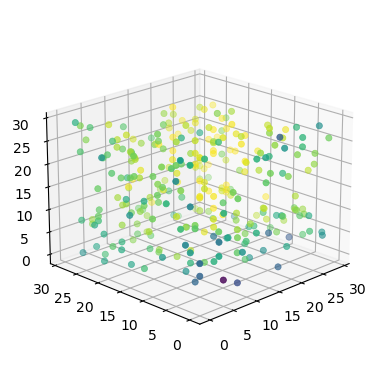

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df["0"], df["1"],df["2"], c = df["value"], cmap='viridis', linewidth=0.5)
# Set zoom and angle view
ax.view_init(20, -135, 0)
ax.set_box_aspect(None, zoom=0.9)

<Axes: xlabel='0', ylabel='value'>

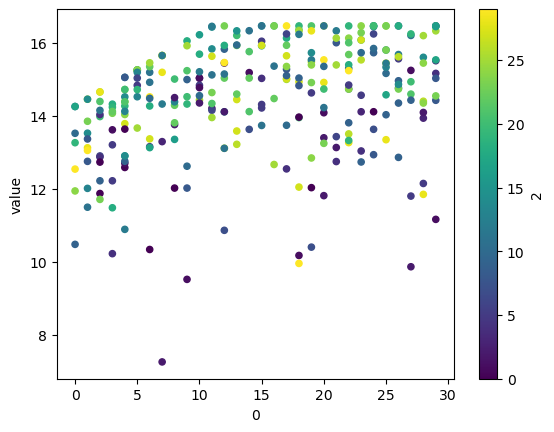

In [6]:
df.plot(kind='scatter',x='0',y='value', c='2')

In [7]:
df

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,value
0,0,1.0,27.0,23.0,5.0,12.0,23.0,4.0,26.0,28.0,10.0,6.0,22.0,13.853273
1,1,29.0,27.0,11.0,16.0,21.0,29.0,15.0,9.0,3.0,27.0,27.0,0.0,16.470120
2,2,28.0,5.0,3.0,20.0,7.0,10.0,5.0,23.0,23.0,29.0,13.0,26.0,13.938988
3,3,20.0,17.0,25.0,20.0,15.0,15.0,21.0,27.0,22.0,23.0,8.0,5.0,16.470120
4,4,11.0,26.0,14.0,9.0,15.0,20.0,5.0,19.0,25.0,7.0,19.0,17.0,16.438627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,17.0,14.0,24.0,18.0,18.0,8.0,3.0,7.0,0.0,23.0,6.0,20.0,15.357107
296,296,12.0,28.0,11.0,5.0,20.0,0.0,11.0,22.0,3.0,16.0,14.0,15.0,15.149593
297,297,17.0,7.0,22.0,17.0,9.0,15.0,12.0,6.0,12.0,1.0,28.0,15.0,15.938085
298,298,2.0,24.0,11.0,26.0,29.0,7.0,4.0,12.0,8.0,23.0,21.0,27.0,14.152987


In [8]:
bids = pd.read_csv("../data\cost_function\dataset_0.csv").to_numpy()[:,1:]

1/(bids[:,:-1].sum(axis=1)/bids[:,-1])

array([0.07408167, 0.07696318, 0.0725989 , 0.07555101, 0.08790709,
       0.08701449, 0.08415032, 0.09679414, 0.09544645, 0.08773668,
       0.08570418, 0.07918327, 0.07902297, 0.09059831, 0.08318604,
       0.08991398, 0.0608605 , 0.0715041 , 0.0807151 , 0.07591214,
       0.08085079, 0.08344196, 0.07428004, 0.07329336, 0.08447613,
       0.08634731, 0.08976721, 0.0889878 , 0.0989157 , 0.07636313,
       0.09345893, 0.07998227, 0.06581877, 0.08463796, 0.09658633,
       0.09314123, 0.08063194, 0.07030808, 0.08009755, 0.11264841,
       0.08250118, 0.09024266, 0.10643362, 0.08084496, 0.07474365,
       0.0726458 , 0.07646922, 0.09604334, 0.09924912, 0.07974493,
       0.07468504, 0.09556953, 0.06662561, 0.08380226, 0.08521081,
       0.07995438, 0.0872076 , 0.08564004, 0.08627661, 0.0628064 ,
       0.06920218, 0.07826152, 0.11740115, 0.06738652, 0.07803366,
       0.08267531, 0.09819527, 0.08194871, 0.07795311, 0.1010968 ,
       0.08997553, 0.08027337, 0.07235508, 0.08406375, 0.07696

In [11]:
import torch 
import random 
from mlca_for_elec.networks.main import eval_config
import os
import matplotlib.pyplot as plt
from mlca_for_elec.env.env import Microgrid, HouseHold
import json
import numpy as np

In [5]:
def evaluate_network(cfg: dict, seed: int, MicroGrid_instance: str, bidder_id: str, num_train_data: int, layer_type: str,
                     normalize: bool, normalize_factor: float, eval_test=False, save_datasets=False):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return eval_config(
        seed=seed, SAT_instance=MicroGrid_instance, bidder_id=bidder_id,
        layer_type=layer_type, batch_size=cfg['batch_size'], num_hidden_layers=cfg['num_hidden_layers'],
        num_hidden_units=int(max(1, np.round(cfg['num_neurons'] / cfg['num_hidden_layers']))), l2=cfg['l2'],
        lr=cfg['lr'], normalize_factor=normalize_factor, optimizer=cfg['optimizer'], num_train_data=num_train_data,
        eval_test=True, epochs=cfg['epochs'], loss_func=cfg['loss_func'], normalize=normalize, save_datasets=False, log_path="logs")

Start loading household profiles
0
1
2
Loaded 3 households
Start compute social welfare
0     11.0589
1     11.0673
2     10.8528
3     10.6791
4      8.4273
5      8.4282
6      8.8509
7      9.0588
8      0.9795
9      0.9729
10     1.0017
11     0.9732
Name: consumption, dtype: float64
Selected hyperparameters {'batch_size': 1, 'epochs': 300, 'l2': 0.01, 'loss_func': 'F.l1_loss', 'lr': 0.0001, 'num_hidden_layers': 5, 'num_neurons': 500, 'optimizer': 'Adam'}
(300, 13)
(50, 12) (50,) (60, 12) (60,) (190, 12) (190,)


100%|██████████| 300/300 [00:42<00:00,  7.01it/s]


[15.052138687730803, 12.755008239505969, 14.726543627964475, 15.787979438948923, 15.2137149882617, 9.13367936704367, 14.552575383612293, 14.661852831641, 13.472881997472314, 12.813963970012765, 16.43062880658067, 16.10722979991806, 12.310039973946687, 14.017081038077094, 15.664940581707924, 13.080364747236445, 15.081125214325994, 14.261465327613223, 16.076369216382773, 13.679518126997664, 10.285347731013417, 15.952958296501492, 14.185407477696572, 14.633456304113906, 16.463690351697778, 14.771731077389632, 14.036557879193651, 11.794098060090846, 14.537548568744796, 15.06269191565434, 13.210355972863908, 14.987826825916954, 10.070571381400441, 14.50448898701893, 12.793969775304049, 14.49091508167021, 13.892631484229014, 16.021735891694334, 13.135653844599574, 14.233877717277664, 15.994262158050788, 14.935541717153455, 15.935644130837545, 15.499999028588945, 15.139578316674942, 13.377992280461967, 15.786130906094968, 15.479983236576572, 15.578084079962537, 14.461705710169099, 13.64913464

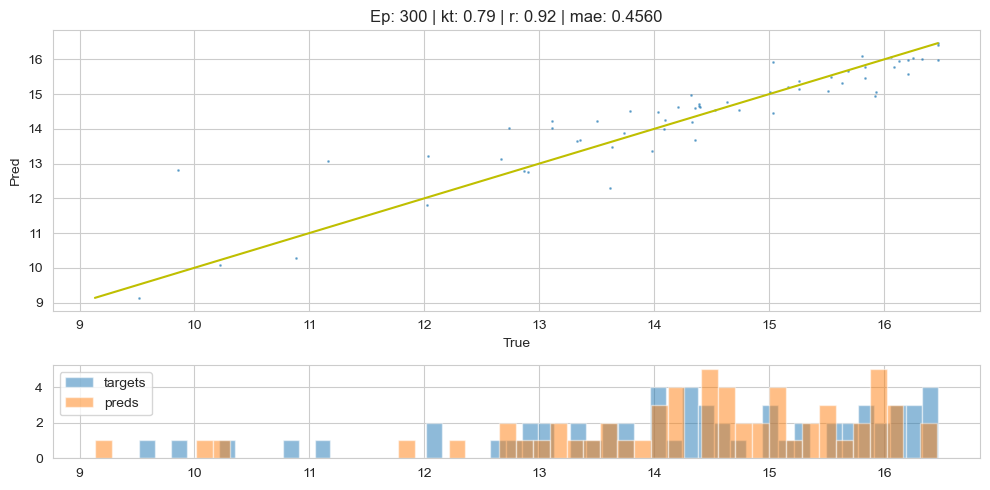

[15.797945612891226, 15.237908876836173, 16.314267442952314, 12.20717790679987, 14.402253241678181, 15.225286234544, 13.83899261720444, 12.465935201920047, 14.286213874213445, 9.809566985004267, 15.119193407109151, 15.847831457557504, 15.355526810859146, 14.683574810642313, 16.3457700554236, 10.609722543123098, 14.88590620487048, 14.736596191121407, 15.627063819570822, 14.927381863153414, 15.415640942198479, 15.434513058812627, 15.142378112585448, 14.761347682808491, 13.634344421311198, 14.170697750514591, 12.28116928743475, 14.595020957168572, 15.351065985958257, 13.210686804288116, 15.135333464810628, 13.578387770925929, 15.084847804120045, 14.390332511754877, 14.184940190581074, 13.919777331535215, 16.08849021221272, 14.936120917569724, 12.048126527405657, 15.068509443903167, 14.909606300547694, 14.956988821380946, 15.070724149223679, 16.307187454135146, 14.592153424260232, 14.58516669652704, 16.007163601899265, 15.773146999814344, 14.779668086483753, 12.964398025247647, 15.83603834

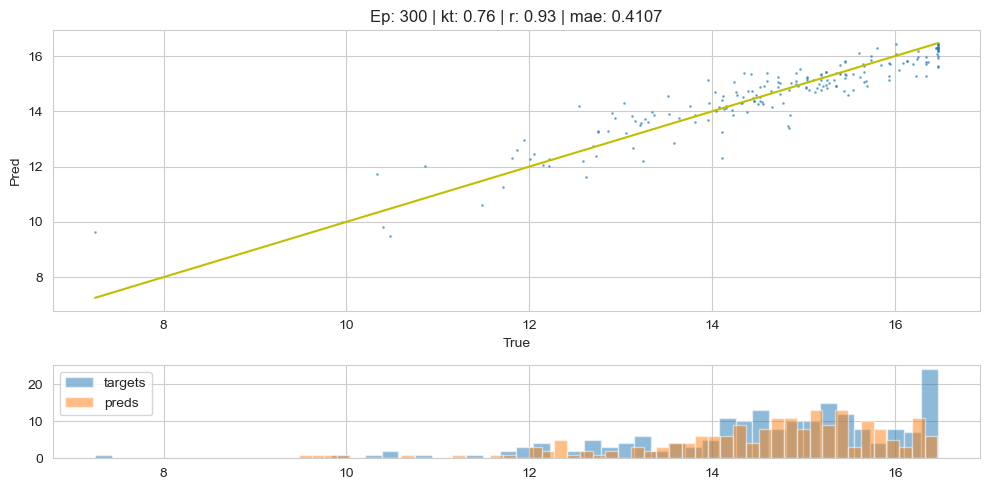

Train metrics 	| pearson corr.: 0.996, KT: 0.963
Valid metrics 	| pearson corr.: 0.916, KT: 0.787
Test metrics 	| pearson corr.: 0.930, KT: 0.763


In [6]:
print("Start loading household profiles")
folder_path = "../config\household_profile\\"
houses = []
for file in os.listdir(folder_path)[:3]:
    if file.endswith(".json"):
        household = json.load(open(folder_path+"/"+ file))
    house = HouseHold(household)

    generation_path = "../data\solar_prod\Timeseries_55.672_12.592_SA2_1kWp_CdTe_14_44deg_-7deg_2020_2020.csv"
    consumption_path = f"../data/consumption/Reference-{house.param['consumption']['type']}.csv"
    spot_price_path = "../data/spot_price/2020.csv"
    fcr_price_path = "../data/fcr_price/random_fcr.csv"
    house.load_data(generation_path,consumption_path, spot_price_path,fcr_price_path)
    for i in range(205):
        house.next_data()
    houses.append(house)
print(f"Loaded {len(houses)} households")
print("Start compute social welfare")
print(houses[0].data['consumption'])
microgrid_1 =json.load(open("../config\microgrid_profile\default_microgrid.json"))
MG = Microgrid(houses, microgrid_1)
# MG.generate_dataset(0)
config_dict = {"batch_size": 1,
        "epochs":300,
        "l2": 1e-2,
        "loss_func": "F.l1_loss",
        "lr": 0.0001,
        "num_hidden_layers":5,
        "num_neurons": 500,
        "optimizer": "Adam"
    }

print('Selected hyperparameters', config_dict)
model, logs = evaluate_network(
    config_dict, seed=0, MicroGrid_instance=MG, bidder_id=1,
    num_train_data=50, layer_type="CALayerReLUProjected",
    normalize=True,
    normalize_factor=1)
train_logs = logs['metrics']['train'][config_dict['epochs']]
val_logs = logs['metrics']['val'][config_dict['epochs']]
test_logs = logs['metrics']['test'][config_dict['epochs']]

print('Train metrics \t| pearson corr.: {:.3f}, KT: {:.3f}'.format(train_logs['r'], train_logs['kendall_tau']))
print('Valid metrics \t| pearson corr.: {:.3f}, KT: {:.3f}'.format(val_logs['r'], val_logs['kendall_tau']))
print('Test metrics \t| pearson corr.: {:.3f}, KT: {:.3f}'.format(test_logs['r'], test_logs['kendall_tau']))

In [8]:
X,Y = np.meshgrid(np.linspace(0,20,100),np.linspace(0,20,100))
vec = np.zeros(12)
Z = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        vec[0] = X[i,j]
        vec[1] = Y[i,j]
        Z[i,j] = model(torch.tensor(vec).float()).detach().numpy()

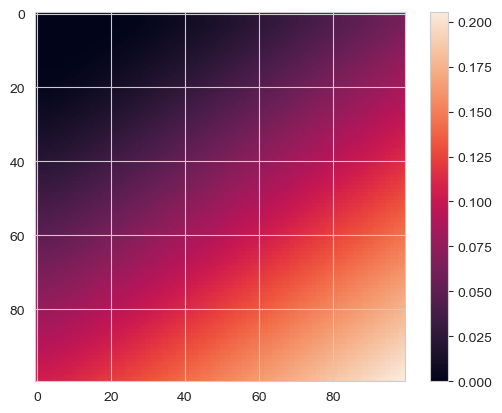

In [13]:
plt.imshow(Z)
plt.colorbar()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')